# Ponder This - Feb

In the famous Snakes and Ladders game, there is a board with 100 squares. You start at square 0 (just outside of the board) and then proceed to advance based on your move, which is dictacted by the throw of a fair dice. If your piece lands on a square that is at the very bottom of a ladder, you climb it. If your turn lands you at the head of a snake, you slide down to the botttom of its tail. And if your turn takes you out of the board (a square > 100), you stay in the square where you are at the time the dice was thrown.

Your challenge this month is to design a game with 10 ladders and snakes altogether that will lead to an expected number of moves (rounded to the 6th decimal place) of 66.978705.

Provide your answer as a list of 10 [source,target] pairs.

As an example, the standard game of 26, with 13 ladders and 13 snakes:

```
[1,38],[4,14],[9,31],[21,42],[28,84],[36,44],[51,67],[71,91],[80,100],[16,6],[47,26],[49,11],[56,53],[62,19],[64,60,],[87,24],[93,73],[95,75],[98,78] 
```

has an expected 39.225122 moves (again, rounded to the 6th decimal place).

---

## Markov Chains, and Absorbing Markov Chains

https://www.dartmouth.edu/~chance/teaching_aids/books_articles/probability_book/Chapter11.pdf

In [1]:
import numpy as np

In [2]:
!pip install frigidum --upgrade

Requirement already up-to-date: frigidum in /usr/local/lib/python3.6/dist-packages (0.1.9)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
classic_snakes_and_ladders = [[1,38],[4,14],[9,31],[21,42],[28,84],[36,44],[51,67],[71,91],[80,100],[16,6],[47,26],[49,11],[56,53],[62,19],[64,60,],[87,24],[93,73],[95,75],[98,78]]

In [4]:
solution = [[1, 32], [17, 16], [19, 53], [30, 7], [35, 44], [62, 3], [72, 83], [78, 28], [95, 47], [97, 40]]
solution_alt = [[91, 19], [94, 82], [18, 87], [69, 50], [93, 20], [10, 49], [43, 40], [48, 28], [12, 79], [59, 71]]

In [5]:
def transition_matrix(ladder_snake_list, board_size=101):
    """
        Create a Transition Matrix, from a list of pairs
        
    """
    board = np.zeros((board_size,board_size))
    
    ladder_dict = { h:t for h,t in ladder_snake_list }

    for square in range(board.shape[0]):
        # Calculate where from current position *square*, we can go next (without ladders/snakes)
        next_squares_all = [square + next_few + 1 for next_few in range(6) ]
        
        # Removed when outsize of the board
        next_squares = [n for n in next_squares_all if n < board_size]

        for next_square in next_squares:
            if next_square in ladder_dict:
                board[square,ladder_dict[next_square] ] += 1
            else:
                board[square,next_square ] += 1

        #
        # Correction when we are at the edge of the board
        if len(next_squares) < 6:
            missed_squares = 6 - len(next_squares)
            board[square,square] += missed_squares
            
    board = board/6
    return board

board = transition_matrix(classic_snakes_and_ladders)

In [6]:
def transition_matrix_fast(ladder_snake_list, board_size=101):
    """
        Create a Transition Matrix, from a list of pairs
        
        faster implementation
    
    """
    board = np.zeros((board_size,board_size))

    for shift in range(1,7):
        diag = np.diag_indices(n=board_size)
        diag_shifted = (diag[0], diag[1] + shift)
        diag_shifted_clipped = (diag_shifted[0][:-shift], diag_shifted[1][:-shift])
        board[diag_shifted_clipped] = 1
    
    for pair in ladder_snake_list:
        row = max(0,pair[0]-6)
        col = pair[1]
        size = 6
        
        
        board[row:row+size,pair[1]] += board[row:row+size,pair[0]]
        board[row:row+size,pair[0]] = 0
        
    board[board_size-1, board_size-1] += 6
    board[board_size-2, board_size-2] += 5
    board[board_size-3, board_size-3] += 4
    board[board_size-4, board_size-4] += 3
    board[board_size-5, board_size-5] += 2
    board[board_size-6, board_size-6] += 1
    
    board = board/6

    return board
    

In [7]:
solution_board = transition_matrix(solution)

In [8]:
np.sum(solution_board, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
board = transition_matrix(classic_snakes_and_ladders)

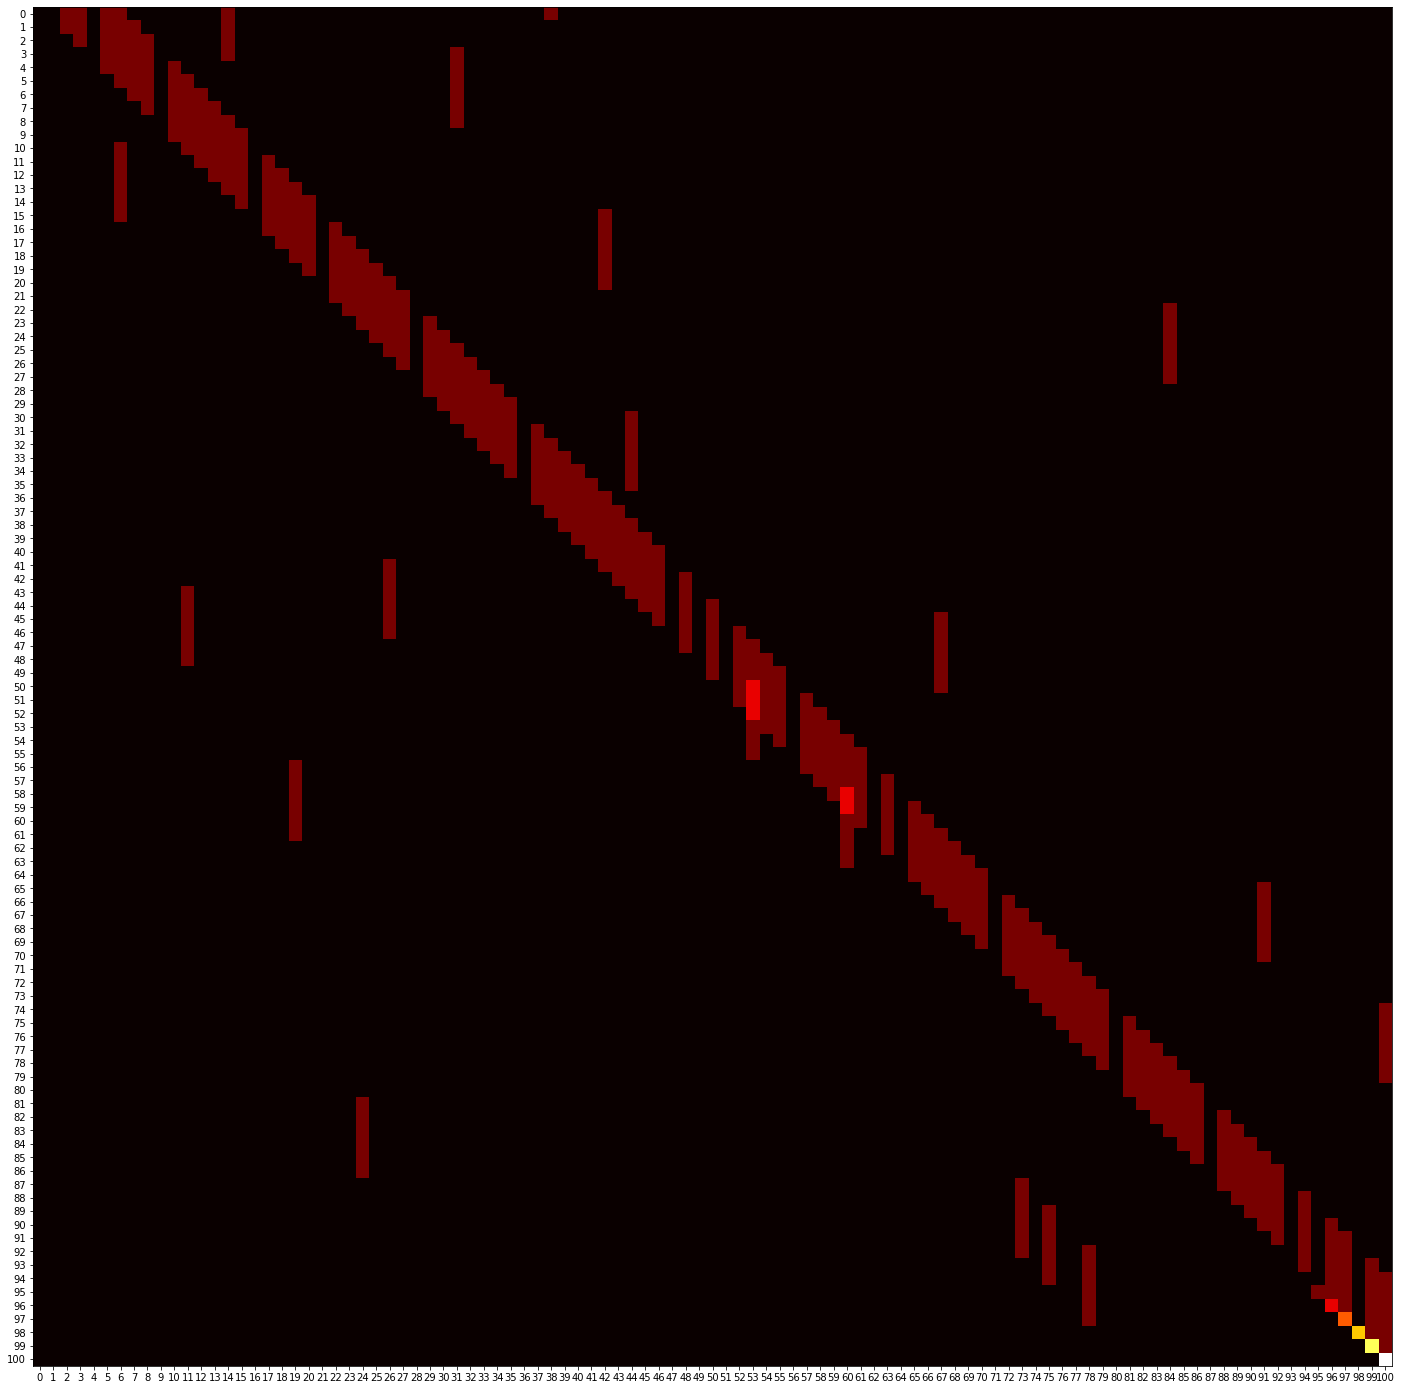

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.imshow(board, cmap='hot', interpolation='nearest')
plt.xticks(range(101))
plt.yticks(range(101))
plt.show()

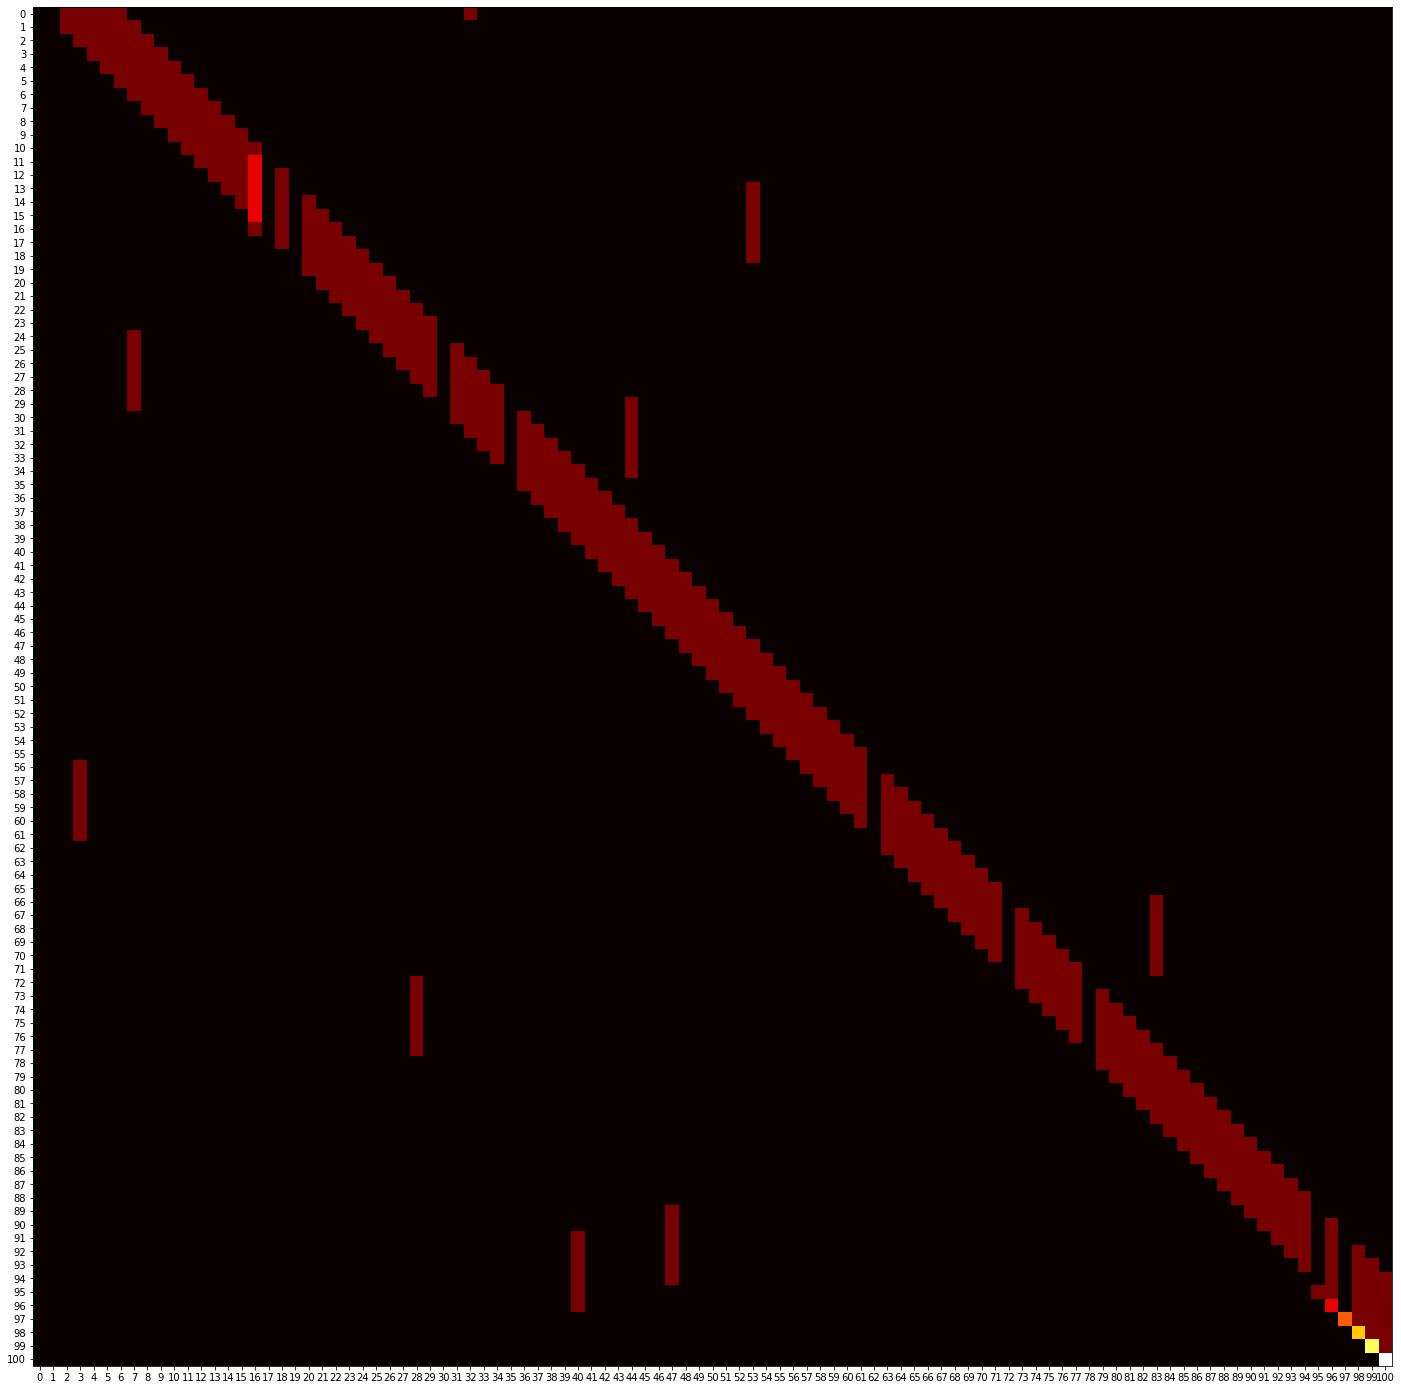

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.imshow(solution_board, cmap='hot', interpolation='nearest')
plt.xticks(range(101))
plt.yticks(range(101))
plt.show()

In [12]:
def transient_submatrix(P):
    size = P.shape[0]
    return P[:size-1,:size-1]

def fundamental_matrix(P):
    size = P.shape[0]
    Q = transient_submatrix(P)
    I = np.identity(size-1)
    N = np.linalg.inv(I-Q)
    return N

def time_to_absorb(P):
    size = P.shape[0]
    return np.matmul( fundamental_matrix(P)[0], np.ones((size-1,1)) )

def time_game_to_finish(P):
    return time_to_absorb(P)[0]

In [13]:
time_game_to_finish(board)

39.2251223082349

In [14]:
time_game_to_finish(solution_board)

66.97870512853407

## Simulated Annealing Scheme in Python

- Proposal functions (move/modify ladders & snakes)
- Cooling Scheme

In [15]:
import frigidum

In [16]:
def random_board_start():
    random_head_and_tails = np.random.choice(range(100),size=20, replace=False)
    
    return list(zip(random_head_and_tails[:10],random_head_and_tails[10:]))

def random_start():
    return random_board_start()

In [17]:
def cost_function(board_configuration):
    tm = transition_matrix_fast(board_configuration)
    return time_game_to_finish(tm)

def delta_cost_function(board_configuration):
    SOLUTION = 66.978705
    return abs(cost_function(board_configuration)-SOLUTION)

In [18]:
def random_snadder_resize(board_configuration, width=3):
    """
        Take a random snake/ladder and resize it.
        
        Only resize its tail or head, but not both.
    """
    snadder_index = np.random.randint(10)
    board_configuration = board_configuration.copy()
    
    all_snadders = list(zip(*board_configuration))[0] + list(zip(*board_configuration))[1]

    allowed_snadders = list( set(range(1,100)) - set(all_snadders) )
    
    snadder_pair = board_configuration[snadder_index]
    #print(snadder_pair)
    
    if np.random.random() > .5:
        """
            Change Head
        """
        snad = snadder_pair[0]
        #print(snad)
        
        close_allowed_snadders = [snadder for snadder in allowed_snadders if abs(snadder-snad) < width]
        if close_allowed_snadders:
            new_snadder = np.random.choice(close_allowed_snadders)
            board_configuration[snadder_index] = [ new_snadder, snadder_pair[1]]
        
    else:
        """
            Change Tail
        """
        snad = snadder_pair[1]
        #print(snad)
        close_allowed_snadders = [snadder for snadder in allowed_snadders if abs(snadder-snad) < width]
        if close_allowed_snadders:
            new_snadder = np.random.choice(close_allowed_snadders)
            board_configuration[snadder_index] = [ snadder_pair[0], new_snadder]

    return board_configuration

In [19]:
def random_snadder_movement(board_configuration):
    """
        Take a random snake/ladder and moves it up or down.
    """
    snadder_index = np.random.randint(10)
    board_configuration = board_configuration.copy()
    
    all_snadders = list(zip(*board_configuration))[0] + list(zip(*board_configuration))[1]

    allowed_snadders = list( set(range(1,100)) - set(all_snadders) )
    
    snadder_pair = board_configuration[snadder_index]
    
    deltas = [-5,-2,-1,1,2,5]
    valid_deltas = []
    for delta in deltas:
        if snadder_pair[0] + delta in allowed_snadders and snadder_pair[1] + delta in allowed_snadders:
            valid_deltas.append(delta)
    
    if valid_deltas:
        chosen_delta = np.random.choice(valid_deltas)
        board_configuration[snadder_index] = [snadder_pair[0]+chosen_delta,snadder_pair[1]+chosen_delta]
    return board_configuration
        

In [20]:
def random_snadder_resize_with_compensation(board_configuration):
    """
        Take a random snake/ladder and resize it.
        
        After resizing snake/ladder, try compensate for the action by
        resizing a other random snake/ladder.
        
        The direction of the compensation resizing is chosen to make sense,
        i.e. when one ladder is grown, other ladder should shrink.
        
    """    
    
    snadder_indices = np.random.choice(range(9),size=2,replace=False)
    
    potential_board_configuration = board_configuration.copy()
    
    snadder_a = board_configuration[snadder_indices[0]]
    snadder_b = board_configuration[snadder_indices[1]]
    
    new_snadder_a = random_resize(snadder_a, potential_board_configuration)
    potential_board_configuration[snadder_indices[0]] = new_snadder_a
    
    new_snadder_b = None
    if has_shrunk(new_snadder_a, snadder_a):
        if is_ladder(snadder_a):
            if is_ladder(snadder_b):
                new_snadder_b = random_grow(snadder_b, potential_board_configuration)
            else:
                new_snadder_b = random_shrink(snadder_b, potential_board_configuration)
        else:
            if is_ladder(snadder_b):
                new_snadder_b = random_shrink(snadder_b, potential_board_configuration)
            else:
                new_snadder_b = random_grow(snadder_b, potential_board_configuration)
    else:
        if is_ladder(snadder_a):
            if is_ladder(snadder_b):
                new_snadder_b = random_shrink(snadder_b, potential_board_configuration)
            else:
                new_snadder_b = random_grow(snadder_b, potential_board_configuration)
        else:
            if is_ladder(snadder_b):
                new_snadder_b = random_grow(snadder_b, potential_board_configuration)
            else:
                new_snadder_b = random_shrink(snadder_b, potential_board_configuration)
    
    potential_board_configuration[snadder_indices[1]] = new_snadder_b
    
    return potential_board_configuration

In [21]:
def is_ladder( pair ):
    return pair[0] < pair[1]

def has_shrunk( new_pair, old_pair ):
    return abs( np.diff(new_pair)[0] ) < abs( np.diff(old_pair)[0] )

def random_resize_helper(pair, possible_new_ends):
    new_pair = list(pair)
    
    if possible_new_ends:
        new_end = np.random.choice(possible_new_ends)
        
        end_diff = [abs(i-new_end) for i in pair]
        
        if end_diff[0] > end_diff[1]:
            new_pair[1] = new_end
        else:
            new_pair[0] = new_end
        
        return new_pair
    else:
        return pair
    
def random_resize(pair, board_configuration):
    all_snadders = list(zip(*board_configuration))[0] + list(zip(*board_configuration))[1]
    allowed_snadders = list( set(range(1,100)) - set(all_snadders) )
    possible_new_ends = [ i for i in allowed_snadders if abs(i-pair[0]) < 2 or abs(i-pair[1]) < 2]
    
    return random_resize_helper(pair, possible_new_ends)
    
def random_shrink(pair, board_configuration):
    pair_is_ladder = is_ladder(pair)
    
    all_snadders = list(zip(*board_configuration))[0] + list(zip(*board_configuration))[1]
    allowed_snadders = list( set(range(1,100)) - set(all_snadders) )
    
    if pair_is_ladder:
        possible_new_ends = [ i for i in allowed_snadders if i-pair[0] == 1 or i-pair[1] == -1]
    else:
        possible_new_ends = [ i for i in allowed_snadders if i-pair[0] == -1 or i-pair[1] == 1]
            
    return random_resize_helper(pair, possible_new_ends)

def random_grow(pair, board_configuration):
    pair_is_ladder = is_ladder(pair)
    
    all_snadders = list(zip(*board_configuration))[0] + list(zip(*board_configuration))[1]
    allowed_snadders = list( set(range(1,100)) - set(all_snadders) )
    
    if not pair_is_ladder:
        possible_new_ends = [ i for i in allowed_snadders if i-pair[0] == 1 or i-pair[1] == -1]
    else:
        possible_new_ends = [ i for i in allowed_snadders if i-pair[0] == -1 or i-pair[1] == 1]
            
    return random_resize_helper(pair, possible_new_ends)

In [22]:
def random_new_configuration(board_configuration):
    q = np.random.random()
    
    if q > .66:
        return random_snadder_resize(board_configuration)
    if q > .33:
        return random_snadder_movement(board_configuration)
    if q >= .0:
        return random_snadder_resize_with_compensation(board_configuration)

In [ ]:
local_opt = frigidum.sa(random_start=random_start, 
                        objective_function=delta_cost_function, 
                        neighbours=[random_new_configuration],
                        T_start=4, 
                        T_stop=0.001,
                        alpha=0.99, 
                        repeats=10**2)



In [29]:
local_opt_board = transition_matrix_fast(local_opt[0])

In [30]:
time_game_to_finish(local_opt_board)

66.97867885814433

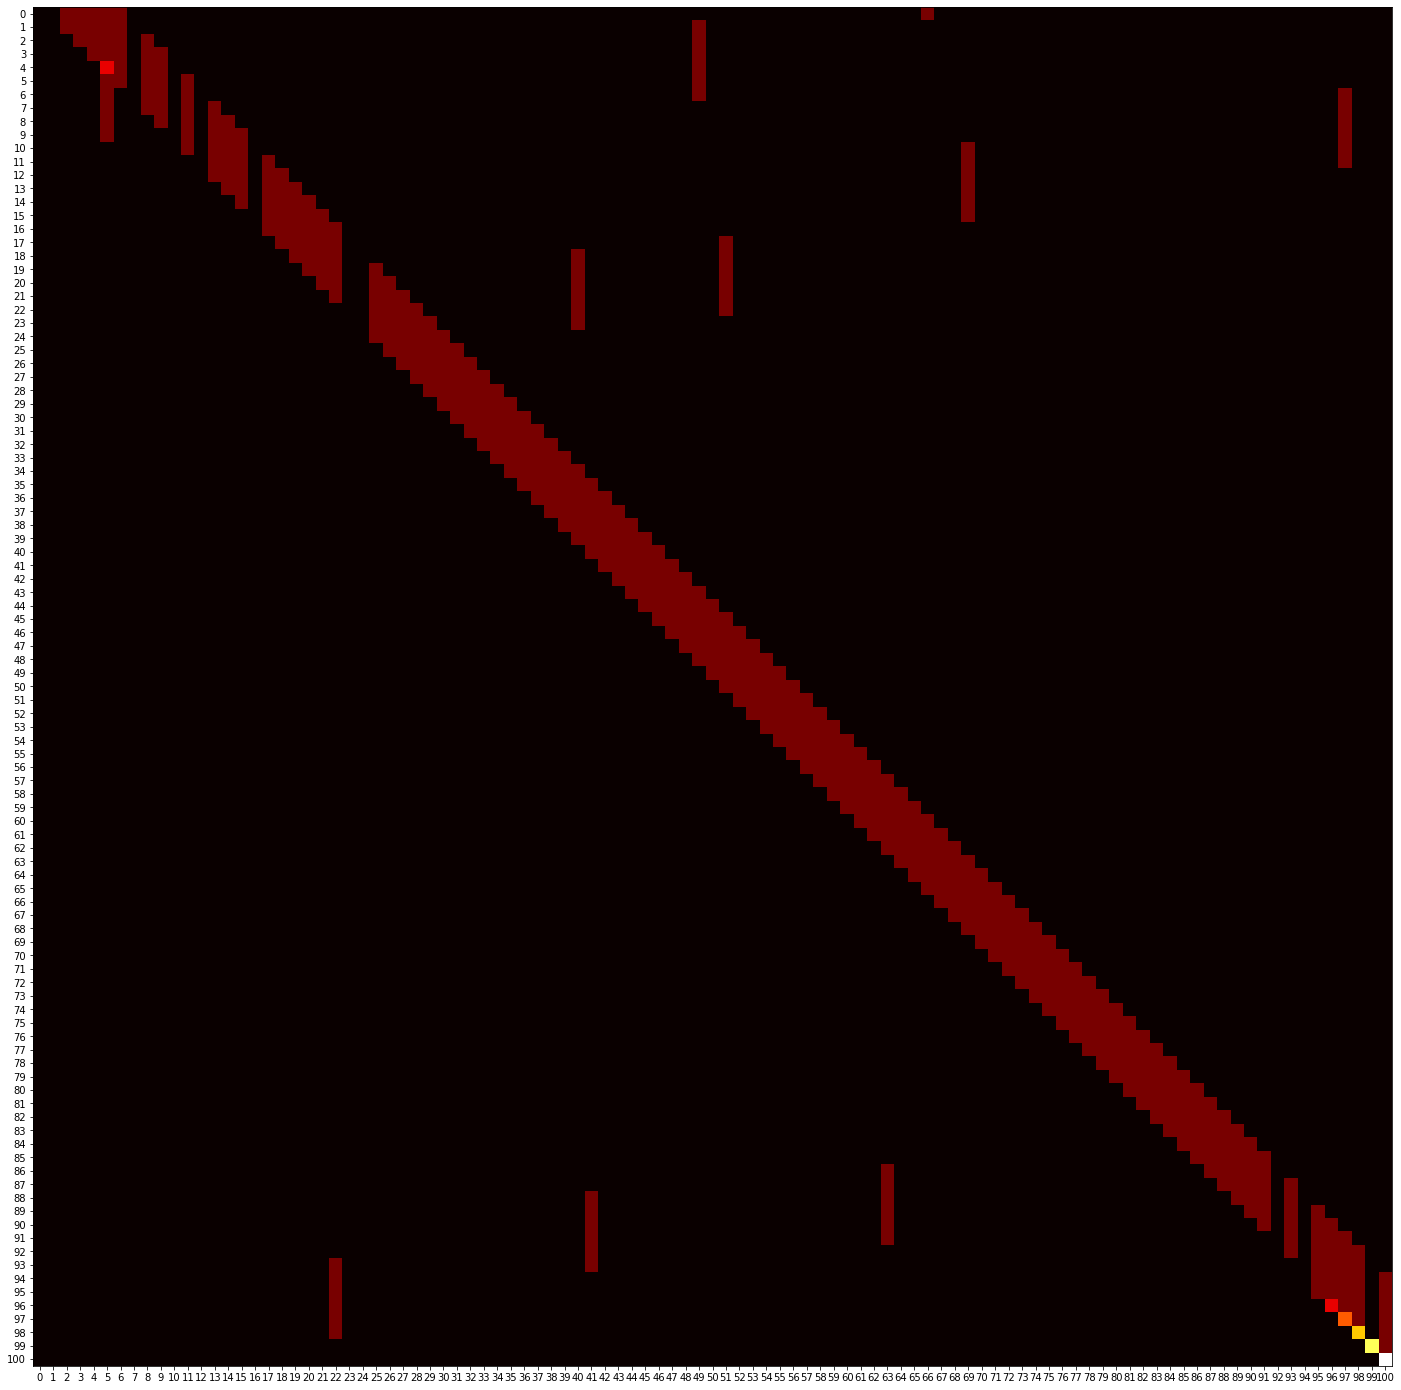

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.imshow(local_opt_board, cmap='hot', interpolation='nearest')
plt.xticks(range(101))
plt.yticks(range(101))
plt.show()